# Weak Kindey XGB Classifier

In [1]:
import some_load_train_evaluate_functions as ml

In [2]:
path = '../KG/db.env'

driver = ml.connect_to_neo4j(path)

Connected to database successfully.


### Load Data

In [3]:
# Weak/Failing kidneys data

weak_kidney_df = ml.get_data_of_disease(driver, 'Weak/Failing kidneys')
weak_kidney_df

,Respondent_ID,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],...,Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L],Weak/Failing kidneys
0,93705,0,66,31.7,89.9,1.517241,0.138,0.071,26.006,1.0,...,28.70,21.0,11.9,NaN,NaN,174.0,28.0,39.8,NaN,0
1,93708,0,66,23.7,116.0,1.218750,0.192,0.127,NaN,0.7,...,109.00,22.0,13.2,58.32,2.870,247.0,32.0,30.1,0.655,0
2,93709,0,75,38.9,72.8,1.121212,0.009,0.017,28.561,0.6,...,129.00,31.0,15.4,NaN,NaN,NaN,21.0,46.5,NaN,0
3,93711,1,56,21.3,165.0,1.290323,0.173,0.079,31.115,0.4,...,40.60,19.0,14.7,31.68,4.086,139.0,16.0,34.8,0.542,0
4,93713,1,67,23.5,63.5,2.047619,0.028,0.028,18.344,0.6,...,238.00,26.0,14.2,NaN,NaN,123.0,27.0,28.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5555,102950,1,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5556,102952,0,70,20.0,82.7,1.846154,0.235,0.077,31.347,0.6,...,135.00,18.0,13.4,26.34,1.112,168.0,39.0,29.1,0.881,0
5557,102953,1,42,35.8,49.5,1.142857,0.106,0.080,21.873,0.6,...,120.00,28.0,15.5,NaN,NaN,136.0,20.0,28.6,NaN,0
5558,102954,0,41,26.1,50.5,1.500000,0.117,0.056,26.935,1.4,...,1.99,8.0,6.4,56.94,2.793,123.0,5.0,248.0,0.553,0


### Training

In [4]:
xg_boost = ml.XGBClassifier()

# Attributes and Labels

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kidney_df, label = 'Weak/Failing kidneys',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

# Training

xg_boost.fit(X_train.values, y_train.values)

# Accuracy scores

y_pred = xg_boost.predict(X_val)

print('Training Accuracy: ',ml.accuracy_score(y_train, xg_boost.predict(X_train)))

print('Testing Accuracy: ',ml.accuracy_score(y_val, y_pred))

Training Accuracy:  0.997751798561151
Testing Accuracy:  0.9991007194244604


## Feature Selection

### Correlation Analysis

In [5]:
xg_boost_test = ml.XGBClassifier()

In [6]:
pos_corr, neg_corr = ml.get_correlated_features(weak_kidney_df,'Weak/Failing kidneys',pos=0.0,neg=-0.0)

corr_features = list(pos_corr.keys()[1:]) + list(neg_corr.keys())
corr_features.remove('Respondent_ID')

corr_features[:30]

['Creatinine [mg/dL]',
 'Blood Urea Nitrogen [mg/dL]',
 'Retinol [umol/L]',
 'Osmolality [mmol/Kg]',
 'Age',
 'Ferritin [ng/mL]',
 'Uric Acid [mg/dL]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Chromium [nmol/L]',
 'Insulin [pmol/L]',
 'Potassium [mmol/L]',
 'Red cell distribution width [%]',
 'Neutrophil_Lymphocyte Ratio',
 'Lactate Dehydrogenase [IU/L]',
 'Blood lead [umol/L]',
 'C-Reactive Protein [mg/L]',
 'Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Alkaline Phosphatase [IU/L]',
 'Monocyte [%]',
 'Segmented neutrophils [%]',
 'BMI',
 'Platelet_Lymphocyte Ratio',
 'Eosinophils [%]',
 'Globulin [g/dL]',
 'Mean cell volume [fL]',
 'Transferrin receptor [nmol/L]',
 'Systemic Immune‐inflammation Index (SII)',
 'Basophils [%]',
 'Gamma Glutamyl Transferase [IU/L]']

In [7]:
ml.evaluate_feature_set(corr_features, xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.998

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.978

F1-Score: 0.989


### SelectFromModel

In [8]:
sfm_features = ml.select_from_model_features(ml.RandomForestClassifier(),X,y)
sfm_features

['Age',
 'BMI',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Alpha-crypotoxanthin [umol/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Blood manganese [nmol/L]',
 'Creatinine [mg/dL]',
 'Eosinophils [%]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Total Iron Binding Capacity [umol/L]',
 'Uric Acid [mg/dL]',
 'Vitamin C [umol/L]',
 'Alanine Aminotransferase [U/L]',
 'Creatine Phosphokinase [IU/L]',
 'Ferritin [ng/mL]',
 'Lactate Dehydrogenase [IU/L]',
 'Transferrin receptor [nmol/L]']

In [9]:
sfm_features = list(sfm_features)

ml.evaluate_feature_set(sfm_features, xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.978

F1-Score: 0.989


### SelectKBest

In [10]:
k_best_features = ml.select_k_best(X, y, n=30)
k_best_features[:30]

['Creatinine [mg/dL]',
 'Blood Urea Nitrogen [mg/dL]',
 'Retinol [umol/L]',
 'Age',
 'Osmolality [mmol/Kg]',
 'Ferritin [ng/mL]',
 'RBC count [million cells/uL]',
 'Uric Acid [mg/dL]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Hematocrit [%]',
 'Hemoglobin [g/dL]',
 'Albumin [g/dL]',
 'Lymphocyte [%]',
 'Potassium [mmol/L]',
 'Chromium [nmol/L]',
 'Total Iron Binding Capacity [umol/L]',
 'Red cell distribution width [%]',
 'Neutrophil_Lymphocyte Ratio',
 'Lactate Dehydrogenase [IU/L]',
 'Blood lead [umol/L]',
 'C-Reactive Protein [mg/L]',
 'A/G Ratio',
 'Glycohemoglobin [%]',
 'Total Lycopene [umol/L]',
 'Alkaline Phosphatase [IU/L]',
 'Trans-lycopene [umol/L]',
 'Lymphocyte_Monocyte Ratio',
 'Insulin [pmol/L]',
 'Alpha-crypotoxanthin [umol/L]',
 'Monocyte [%]']

In [11]:
ml.evaluate_feature_set(k_best_features[:30], xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### Recursive Feature Elimination (RFE) 

In [12]:
rfe_features = ml.select_rfe_features(ml.XGBClassifier(),X,y,n=30,step=0.5)
rfe_features[:30]

['Iron [ug/dL]',
 'Alanine Aminotransferase [U/L]',
 'LDL_HDL Ratio',
 'Albumin [g/dL]',
 'Trans-beta-carotene [umol/L]',
 'Alkaline Phosphatase [IU/L]',
 'Hematocrit [%]',
 'Non_HDL Ratio',
 'Osmolality [mmol/Kg]',
 'Fasting Glucose [mmol/L]',
 'Eosinophils [%]',
 'Creatinine [mg/dL]',
 'Platelet count [1000 cells/uL]',
 'Triglyceride_HDL Ratio',
 'Chromium [nmol/L]',
 'Cis-beta-carotene [umol/L]',
 'Creatine Phosphokinase [IU/L]',
 'Retinyl palmitate [umol/L]',
 'Retinol [umol/L]',
 'A/G Ratio',
 'Red cell distribution width [%]',
 'Alpha-crypotoxanthin [umol/L]',
 'Chloride [mmol/L]',
 'RBC count [million cells/uL]',
 'Platelet_WBC Ratio',
 'Blood Urea Nitrogen [mg/dL]',
 'Ferritin [ng/mL]',
 'Blood lead [umol/L]',
 'Platelet_Lymphocyte Ratio',
 'Mean cell hemoglobin [pg]']

In [13]:
ml.evaluate_feature_set(rfe_features[:30], xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### Lasso Regularization

In [14]:
l1_selected_features = ml.log_reg_lasso_select(X_train, y_train)
l1_selected_features[:30]

['Creatinine [mg/dL]',
 'Gender',
 'Age',
 'LDL_HDL Ratio',
 'Retinol [umol/L]',
 'Platelet_Lymphocyte Ratio',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Beta-cryptoxanthin [umol/L]',
 'Ferritin [ng/mL]',
 'Phosphorus [mg/dL]',
 'Aspartate Aminotransferase [U/L]',
 'Vitamin C [umol/L]',
 'Alanine Aminotransferase [U/L]',
 'Alkaline Phosphatase [IU/L]',
 'Lutein and zeaxanthin [umol/L]',
 'Total Bilirubin [mg/dL]',
 'Bicarbonate [mmol/L]',
 'Alpha-tocopherol [umol/L]',
 'Blood lead [umol/L]',
 'Total Lycopene [umol/L]',
 'A/G Ratio',
 'Blood Urea Nitrogen [mg/dL]',
 'Blood selenium [umol/L]',
 'Uric Acid [mg/dL]',
 'Transferrin receptor [nmol/L]',
 'Platelet_WBC Ratio',
 'Iron frozen [umol/L]',
 'White blood cell count [1000 cells/uL]',
 'Nucleated RBCs',
 'Iron [ug/dL]']

In [15]:
ml.evaluate_feature_set(l1_selected_features[:30], xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### Relief F

In [16]:
relieff_features = ml.relief_feature_select(30,X,y)

In [17]:
relieff_features[:30]

['Nucleated RBCs',
 'Creatinine [mg/dL]',
 'Blood Urea Nitrogen [mg/dL]',
 'Age',
 'Hemoglobin [g/dL]',
 'Hematocrit [%]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Total Cholesterol [mmol/L]',
 'RBC count [million cells/uL]',
 'Uric Acid [mg/dL]',
 'Non_HDL Ratio',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Neutrophil_Lymphocyte Ratio',
 'Lymphocyte [%]',
 'Albumin [g/dL]',
 'Gender',
 'Transferrin Saturation [%]',
 'Chloride [mmol/L]',
 'UIBC [umol/L]',
 'Glycohemoglobin [%]',
 'Red cell distribution width [%]',
 'Globulin [g/dL]',
 'Total Protein [g/dL]',
 'A/G Ratio',
 'Segmented neutrophils [%]',
 'Total Lycopene [umol/L]',
 'Alpha-tocopherol [umol/L]',
 'Total Iron Binding Capacity [umol/L]',
 'Iron frozen [umol/L]']

In [18]:
ml.evaluate_feature_set(relieff_features[:30], xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### XGBoost Feature Importances

In [19]:
def get_xgb_features(model, X_train):
    
    xgb_features = ml.pd.DataFrame(model.feature_importances_, index=X_train.columns,
                                             columns=['Importance'])
    xgb_features = xgb_features.sort_values('Importance', ascending=False)
    xgb_features = list(xgb_features.index)
    
    return xgb_features

In [20]:
xgb_features = get_xgb_features(xg_boost, X_train)
xgb_features[:30]

['Creatinine [mg/dL]',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Chloride [mmol/L]',
 'Eosinophils [%]',
 'Lymphocyte_Monocyte Ratio',
 'Red cell distribution width [%]',
 'Creatine Phosphokinase [IU/L]',
 'A/G Ratio',
 'Platelet_WBC Ratio',
 'Mean cell volume [fL]',
 'Retinyl palmitate [umol/L]',
 'Blood lead [umol/L]',
 'Sodium [mmol/L]',
 'Alanine Aminotransferase [U/L]',
 'Total Bilirubin [mg/dL]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Mean platelet volume [fL]',
 'Alkaline Phosphatase [IU/L]',
 'Globulin [g/dL]',
 'Iron frozen [umol/L]',
 'Neutrophil_Lymphocyte Ratio',
 'Ferritin [ng/mL]',
 'Basophils [%]',
 'Triglyceride [mmol/L]',
 'Beta-cryptoxanthin [umol/L]',
 'Transferrin Saturation [%]',
 'RBC count [million cells/uL]',
 'Retinol [umol/L]',
 'C-Reactive Protein [mg/L]']

In [21]:
ml.evaluate_feature_set(xgb_features, xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.998

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.978

F1-Score: 0.989


### Optimal no. of features

In [22]:
final_features = list(xgb_features)

xg_boost_test = ml.XGBClassifier()

Finding optimal no. of features..: 100%|████████| 85/85 [01:56<00:00,  1.37s/it]


Maximum f1 = 0.3651 for 21 features


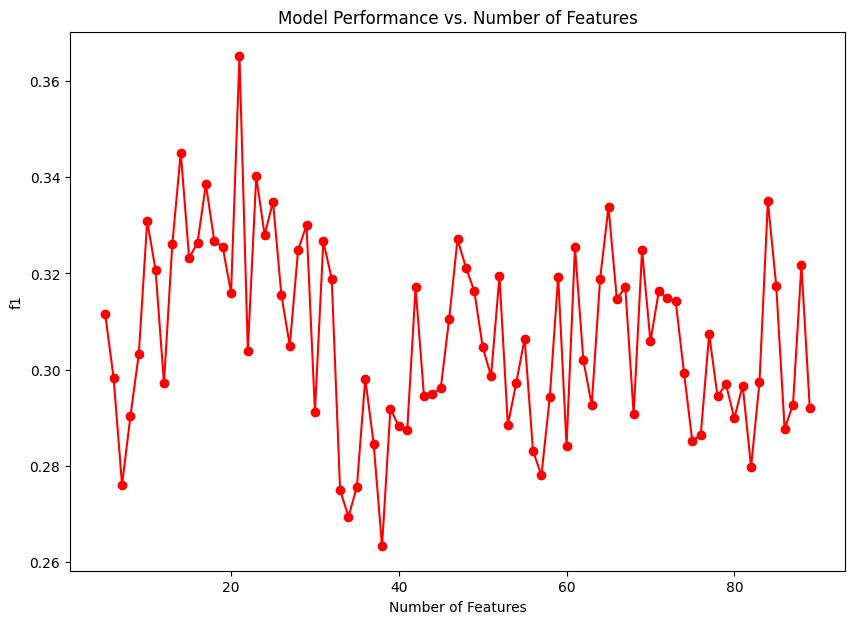

In [23]:
# Optimal no. of features

ml.plot_num_feature_performance(xg_boost_test,  X, y, final_features, scoring='f1', val=True)

Finding optimal no. of features..: 100%|████████| 85/85 [02:04<00:00,  1.46s/it]


Maximum recall = 0.2559 for 21 features


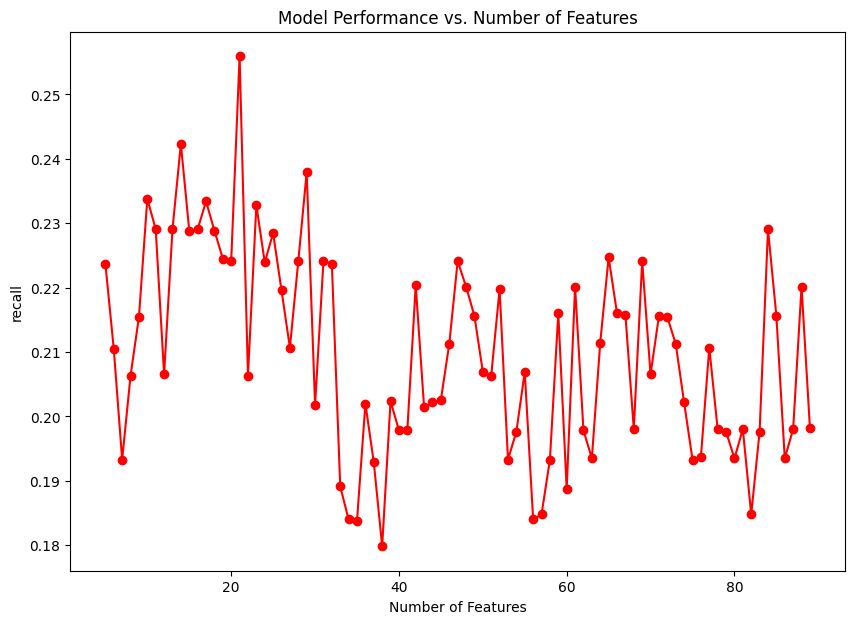

In [24]:
# Optimal no. of features

ml.plot_num_feature_performance(xg_boost_test,  X, y, final_features, scoring='recall', val=True)

In [25]:
num_features = 21

selected = final_features[:num_features]
selected.append('Weak/Failing kidneys')

weak_kidney_df = weak_kidney_df[selected]

In [26]:
# Save feature set
    
with open('../Models/Weak kidneys/Feature Sets/XG Boost Features.pkl', 'wb') as f:
    ml.pickle.dump(selected, f)

## Preprocessing

### Zero Imputation

In [27]:
# Imputing null values with zeroes

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kidney_df, label = 'Weak/Failing kidneys',
                                                        impute = True, scale=True,
                                                        imputer=ml.SimpleImputer(strategy='constant',fill_value=0),
                                                        random_state=42)

In [28]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### Mode Imputation

In [29]:
# Imputing with most frequent values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kidney_df, label = 'Weak/Failing kidneys',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='most_frequent'),
                                                              random_state=42)

In [30]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### Multiple Imputation by Chained Equations (MICE)

In [31]:
# Imputes by looking at data from other columns and trying to estimate the best prediction for each missing value.

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kidney_df, label = 'Weak/Failing kidneys',
                                                              impute = True, scale=True,
                                                              imputer=ml.IterativeImputer(max_iter=20),
                                                              random_state=42)

In [32]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### Median Imputation

In [33]:
# Imputing with median values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kidney_df, label = 'Weak/Failing kidneys',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='median'),
                                                              random_state=42)

In [34]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### Mean Imputation

In [35]:
# Splitting and Preprocessing data

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kidney_df, label = 'Weak/Failing kidneys',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

In [36]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### k-NN Imputation

In [37]:
# Imputing missing values with values from the k-nearest neighbors in the feature space

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kidney_df, label = 'Weak/Failing kidneys',
                                                              impute = True, scale=True,
                                                              imputer=ml.KNNImputer(n_neighbors=20),
                                                              random_state=42)

In [38]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### Dropping Null Values

In [39]:
# Drop null values
weak_kidney_df_na = weak_kidney_df.dropna()

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kidney_df_na, label = 'Weak/Failing kidneys',
                                                              impute = False, scale=True,
                                                              random_state=42)

In [40]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


## Oversampling and Undersampling

### Random Oversampling

In [41]:
X_ros, y_ros = ml.random_over_sample(X_train, y_train)

xg_boost.fit(X_ros.values, y_ros.values)

ml.evaluate_model_metrics(xg_boost,X_ros, y_ros,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### SMOTE (Synthetic Minority Over-sampling Technique)

In [42]:
X_smote, y_smote = ml.smote_over_sample(X_train, y_train)

xg_boost.fit(X_smote.values, y_smote.values)

ml.evaluate_model_metrics(xg_boost,X_smote, y_smote,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### Random Undersampling

In [43]:
X_rus, y_rus = ml.random_under_sample(X_train, y_train)

xg_boost.fit(X_rus.values, y_rus.values)

ml.evaluate_model_metrics(xg_boost,X_rus, y_rus,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 0.769

Precision: 0.124

Recall: 1.000

F1-Score: 0.221


### Tomek Links

In [44]:
X_tomek, y_tomek = ml.tomek_links(X_train, y_train)

xg_boost.fit(X_tomek.values, y_tomek.values)

ml.evaluate_model_metrics(xg_boost,X_tomek, y_tomek,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### SMOTE + Tomek Links

In [45]:
X_smote_tomek, y_smote_tomek = ml.smote_tomek(X_train, y_train)

xg_boost.fit(X_smote_tomek.values, y_smote_tomek.values)

ml.evaluate_model_metrics(xg_boost,X_smote_tomek, y_smote_tomek,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


In [46]:
# Model seems to perform better without oversampling or undersampling

## Hyperparameter Optimization 

In [47]:
param_grid = {
    
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 1.5, 2, 3],
    
}

### Random Search

In [48]:
rand_best_params, xg_boost_rand = ml.random_search_optimize(xg_boost,param_grid,n_iter=100,cv=5,
                                                               X_train=X_train, y_train=y_train,
                                                               scoring='accuracy', val=True)

In [49]:
rand_best_params

{'subsample': 1.0,
 'reg_lambda': 1.5,
 'reg_alpha': 0.1,
 'learning_rate': 0.3,
 'gamma': 0.2}

In [50]:
ml.evaluate_model_metrics(xg_boost_rand,X_train,y_train,X_val,y_val)


Train Accuracy: 0.999

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### Optuna

In [51]:
def objective(trial):

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
    }

    if params['booster'] == 'gbtree' or params['booster'] == 'dart':
        params['subsample'] = trial.suggest_uniform('subsample', 0.1, 1.0)
        params['colsample_bytree'] = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)

    model = ml.XGBClassifier(**params)
    
    model.fit(X_train.values, y_train.values)
    y_pred = model.predict(X_test.values)

    accuracy = ml.accuracy_score(y_test.values, y_pred)

    return accuracy

In [52]:
best_trial , xg_boost_opt = ml.optuna_optimize(objective, ml.XGBClassifier, n_trials=150)

In [53]:
best_trial

{'booster': 'gbtree',
 'lambda': 0.0036404337933692945,
 'alpha': 0.016557212529056065,
 'max_depth': 9,
 'eta': 0.3601622726581256,
 'gamma': 2.9738634874356515e-08,
 'grow_policy': 'depthwise',
 'subsample': 0.8478133114306166,
 'colsample_bytree': 0.4797785463906178}

In [54]:
xg_boost_opt.fit(X_train.values,y_train.values)

ml.evaluate_model_metrics(xg_boost_opt,X_train,y_train,X_val,y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


## Evaluation on Test Set


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000

Confusion Matrix:

[[787   0]
 [  0  34]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       787
     Class 1       1.00      1.00      1.00        34

    accuracy                           1.00       821
   macro avg       1.00      1.00      1.00       821
weighted avg       1.00      1.00      1.00       821


ROC-AUC Curve:


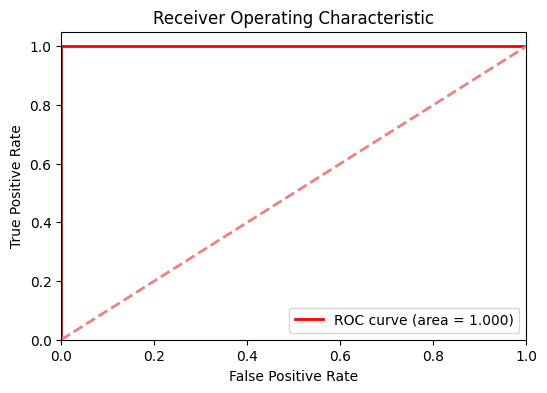

In [55]:
# After evaluating on the validation set, we evaluate and finalize on the test set

ml.evaluate_model_metrics(xg_boost_opt, X_train, y_train, X_test, y_test, verbose=6)

## Cross Validation

### K-fold

In [56]:
ml.k_cross_validate(xg_boost,X.values,y.values,cv=10,scoring='accuracy')


accuracy scores: [0.97087379 0.95631068 0.96116505 0.96097561 0.96585366 0.96585366
 0.95609756 0.97073171 0.96585366 0.96097561]

Mean accuracy score:  0.963469097797774

Standard deviation:  0.004979552333625773


In [57]:
ml.k_cross_validate(xg_boost_rand,X.values,y,cv=10,scoring='accuracy')


accuracy scores: [0.96601942 0.96116505 0.95631068 0.96097561 0.96097561 0.95609756
 0.95609756 0.97073171 0.96585366 0.97073171]

Mean accuracy score:  0.9624958560265215

Standard deviation:  0.005346727301303553


In [58]:
ml.k_cross_validate(xg_boost_opt,X.values,y,cv=10,scoring='accuracy')


accuracy scores: [0.96116505 0.95631068 0.96601942 0.95609756 0.96585366 0.95609756
 0.95609756 0.97073171 0.96585366 0.95121951]

Mean accuracy score:  0.9605446365143264

Standard deviation:  0.005955835424445794


### Stratified K-fold

In [59]:
ml.stratified_k_cross_validate(xg_boost,X,y,n_splits=10)


Average Accuracy: 0.9634667298129292

Average Precision: 0.6166666666666667

Average Recall: 0.2513888888888889

Average F1-Score: 0.33581529581529584


In [60]:
ml.stratified_k_cross_validate(xg_boost_rand,X,y,n_splits=10)


Average Accuracy: 0.9629789249348804

Average Precision: 0.5900000000000001

Average Recall: 0.24027777777777776

Average F1-Score: 0.3246819846819846


In [61]:
ml.stratified_k_cross_validate(xg_boost_opt,X,y,n_splits=10)


Average Accuracy: 0.9620033151787828

Average Precision: 0.4883333333333333

Average Recall: 0.18888888888888888

Average F1-Score: 0.26579087579087585


### Save Model

In [62]:
final_xgb_estimator = xg_boost

In [63]:
# Saving the model

ml.save_model(final_xgb_estimator, "../Models/Weak kidneys/XGBoost_Classifier.pkl")

Saved Model


## Prediction

In [67]:
# Predicting on perturbed values

sc = ml.np.random.rand()

ml.predict_on_modified_instance(final_xgb_estimator, X_test.iloc[0], y_test.iloc[0], 0.6)

Instance:
 [-0.76009431  0.156933   -0.00762033  0.98952267 -0.87565587 -0.98635615
  1.02946427  0.26108936 -1.6466317  -0.08467301 -0.10036053  1.05907278
 -0.5330105   0.60674508 -0.66422354 -1.41225037 -1.43905497 -1.55630944
  0.38058767  1.81762048 -1.72670054]

Expected Class:  0

 Modified Instance:
 [-0.76009431  0.41381213  0.05466063  0.78421584 -1.15636914 -0.84779768
  0.94847743  0.06755235 -1.48142288 -0.15015367 -0.1663764   1.02285634
 -0.55111054  0.37782605 -0.99818815 -1.35183641 -1.48792355 -1.31605016
  0.37290879  1.80382297 -1.80993368]

Predicted Class:  [0]


In [69]:
# Predicting on perturbed values

sc = ml.np.random.rand()

ml.predict_on_modified_instance(final_xgb_estimator, X_test.iloc[34], y_test.iloc[34], 0.6)

Instance:
 [ 2.28919122e+00 -4.34929873e-01  7.30493020e+00  6.22834290e-01
 -4.29098029e-01 -1.28186225e+00  4.35566919e-01 -3.05911417e-01
 -1.19964205e+00 -4.17670748e-04  1.34452799e-01  1.35881725e+00
  2.34599418e-01 -1.59620628e-01 -6.64223544e-01 -1.06009925e+00
 -9.38403542e-01  2.00019572e+00 -1.56850095e-01  8.87714629e-01
 -7.46654759e-01]

Expected Class:  0

 Modified Instance:
 [ 2.28919122 -0.53259021  7.1620856   0.43873192 -0.5506441  -1.33844403
  0.41920459 -0.27935504 -1.16123184  0.16199299  0.47154909  1.21476182
  0.24851345 -0.13732392 -0.72027191 -0.77060363 -1.05765745  1.74915793
 -0.15814376  0.78356022 -0.99318407]

Predicted Class:  [1]


In [70]:
# Predicting on perturbed values

sc = ml.np.random.rand()

ml.predict_on_modified_instance(final_xgb_estimator, X_test.iloc[41], y_test.iloc[41], 0.6)

Instance:
 [ 2.81651127 -0.67625182  3.40490325 -0.11054248 -0.07185176 -0.87659674
  1.40065011 -0.25257966 -0.29795602 -1.32817591 -0.97699698 -0.46962401
  0.23459942  0.22356222 -0.79258876 -0.35579702  0.30086327  0.88878786
  0.22703403 -0.50714415 -0.80696527]

Expected Class:  1

 Modified Instance:
 [ 2.81651127 -0.63708158  3.2576868  -0.03013903 -0.24089461 -0.9829517
  1.35463785  0.04247176 -0.32188172 -1.11210815 -1.06965496 -0.73490887
  0.01435686  0.35604815 -0.72513011 -0.46761916  0.34707017  0.76777831
  0.12157643 -0.42497722 -0.80661718]

Predicted Class:  [1]
